# Предуприждение: расчеты в файле занимают продолжительное время (5 мин)

# Warning: calculations in the file take a long time (5 min)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from pylab import rcParams
from sklearn.datasets import load_boston
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.utils import shuffle

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#Считываем данные из файла
data = pd.read_csv('train.csv')

# Разбивка данных

In [3]:
#Разбивка Data на тренировачный и валидатационный датасет
from sklearn.model_selection import train_test_split
train, valid = train_test_split(data, test_size=0.2, random_state=42)
train.shape, valid.shape

((8000, 20), (2000, 20))

In [4]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9254,12473,58,1.0,65.271225,62.798045,1.0,3,1.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,210849.693542
1561,14050,146,2.0,45.091598,43.816601,1.0,5,18.0,2017,0.236108,B,B,16,3893,27,NaN,3,10,B,201549.998077
1670,3779,5,1.0,34.463114,20.561823,5.0,3,5.0,1960,0.150818,B,B,16,3433,4,2643.0,4,5,B,158433.168775
6087,3762,90,3.0,61.931107,46.126389,5.0,4,5.0,1966,0.265089,B,B,37,5288,0,1937.0,3,2,B,220194.818430
6669,358,1,1.0,42.670840,NaN,1.0,8,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,125834.270291


In [5]:
train.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
      dtype='object')

In [6]:
col = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2']

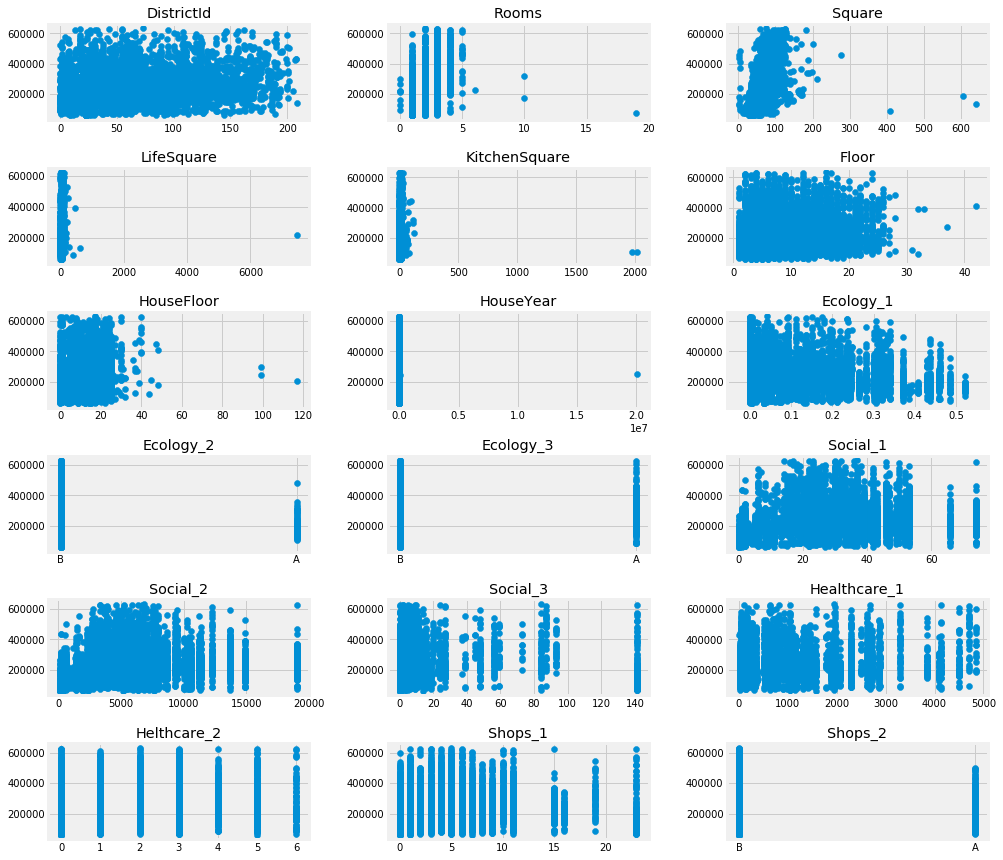

In [7]:
#визуализируем данные
fig, ax = plt.subplots(nrows=6, ncols=3)
ax = ax.flatten()
for i, j in enumerate(col):
    ax[i].scatter(data[j], data['Price'])
    ax[i].set_title(j)
fig.set_size_inches(15, 15)
plt.subplots_adjust(wspace=0.3, hspace=0.5)

In [8]:
#из графиков видно, что некоторые данны выбиваются из обще массы

# Построим матрицу весов (температурную карту)

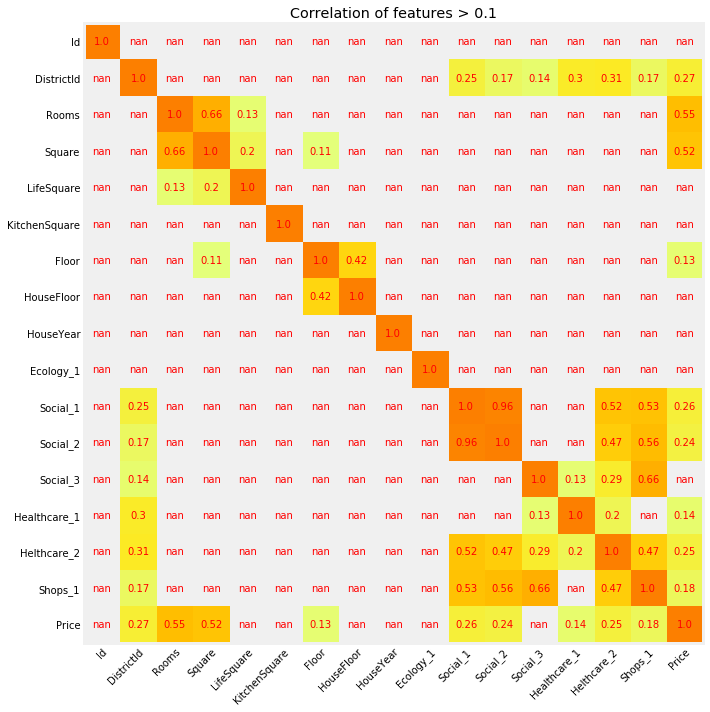

In [9]:
data_columns = data.columns
correlation = data.corr()
# прорисовываем температурную карту (heatmap) по перекрессной корреляции показателей
# для определения наиболее взаимозависимых показателей

# Размер графика
rcParams['figure.figsize'] = 10, 10
# Задаем отсекающий коэффициент корреляции. Ниже этого коэфф. считаем, что корреляция пары показателей не сильная.
correlation_rate_filter = 0.1

#Определяем колонки, столбцы и данные для построение heatmap
hm_index = correlation.index
hm_colums = correlation.columns
hm_data = np.array(correlation.where(correlation > abs(correlation_rate_filter))).round(2)


fig, ax = plt.subplots()
im = ax.imshow(hm_data, cmap="Wistia")

# Столбцы и индексы
ax.set_xticks(np.arange(len(hm_colums)))
ax.set_yticks(np.arange(len(hm_index)))
ax.set_xticklabels(hm_colums)
ax.set_yticklabels(hm_index)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Подписи к столбцам и индексам.
for i in range(len(hm_index)):
    for j in range(len(hm_colums)):
        text = ax.text(j, i, hm_data[i, j],
                       ha="center", va="center", color="r", fontsize=10)

ax.set_title(f"Correlation of features > {correlation_rate_filter}")
fig.tight_layout()
plt.grid()
plt.show()

# Обработка даннх

Т.к. 10 000 считаем что данных мало, поэтому придерживаемся варианта не удаления данных, а заменна средним значением

In [10]:
def clean_house_year(df):
    # Год больше 2020 заменяем 2020
    df.loc[df['HouseYear'] > 2020 , 'HouseYear' ] = 2020 
    return df

In [11]:
def clean_house_floor(df):
    # Самое высокое жилое сдание в России на 2019 г. "Башня Федерация" 62 этажа
    df.loc[df['HouseFloor'] > 62 , 'HouseFloor'] = 62
    df.loc[df['HouseFloor'] < 1 , 'HouseFloor'] = 1
    return df

In [12]:
def clean_floor(df):
    #этаж квартиры не может быть больше этажности дома
    df.loc[(df['Floor']>df['HouseFloor']) & (df['Floor'].isnull() != True ), 'HouseFloor'] = df['Floor']
    return df

In [13]:
def clean_rooms(df):
    # заменим 0 комнаты на 1 и комнаты больше 5 заменим 5
    df.loc[df['Rooms'] > 5 , 'Rooms'] = 5
    df.loc[df['Rooms'] < 1 , 'Rooms'] = 1    
    return df

In [14]:
def clean_square(df):
    #Принимаем гипотезу
    df.loc[df['Square']/df['Rooms'] < 9.0 , 'Square' ] = df['Square'].mean()
    df.drop(df[df.Square > 250.0].index, inplace=True)
    df.drop(df[df.Square < 15.0].index, inplace=True)
    return df

In [15]:
def clean_kitchen_square(df):
    # обработка площади кухни
    df.loc[df['KitchenSquare'] > df['Square']*0.4 , 'KitchenSquare' ] = df['Square']*0.4
    df.loc[df['KitchenSquare'] < 4 , 'KitchenSquare' ] = df['Square']*0.2
    return df

In [16]:
def clean_life_square(df):
    # обработка жилой площади
    df.loc[(df['LifeSquare'] < 9) , 'LifeSquare' ] = df['Square']*0.6
    df.loc[(df['LifeSquare'] + df['KitchenSquare'] >  df['Square'])|\
           (df['LifeSquare'].isnull()), 'LifeSquare' ] = df['Square'] - df['KitchenSquare']
    return df

In [17]:
def add_ground_floor(df):  
    # Проверяем являются ли этажи последними (первый или самым верхним)
    df['ground_floor'] = (df['Floor'] <=1).astype(int)
    df['high_floor'] = (df['Floor'] ==df['HouseFloor']).astype(int)
    return df

In [18]:
def add_district(df, distr_info1):
    # является ли район большим
    df = pd.merge(df, distr_info1, on='DistrictId', how='left')
    df['is_large'] = df['is_large'].fillna(0)
    df['large_district'] = df['large_district'].fillna(1)   
    return df

In [19]:
def translation_of_indicators(df):
    # Ковертация признаков типа STR В INT
    df['Ecology_2'] = (df['Ecology_2'] == 'A').astype(int)
    df['Ecology_3'] = (df['Ecology_3'] == 'A').astype(int)
    df['Shops_2'] = (df['Shops_2'] == 'A').astype(int)
    return df

In [20]:
def add_mean_helthcare(df, stat1, stat2, mean_helthcare):
    # В связи с большим количиством отсудствующих значений Healthcare_1
    # создаем дополнительно 2 поля
    df = pd.merge(df, stat1, on=['DistrictId', 'Helthcare_2'], how='left')
    df = pd.merge(df, stat2, on='Helthcare_2', how='left')
    
    df['mean_healthcare2'] = df['mean_healthcare2'].fillna(mean_helthcare)
    df['mean_healthcare1'] = df['mean_healthcare1'].fillna(df['mean_healthcare2'])
    return df

In [21]:
# Создаем датаврейм по райлнам и проверяем относится район к большому району
distr_info1 = train['DistrictId'].value_counts().reset_index().\
    rename(columns={'index':'DistrictId', 'DistrictId':'large_district'})
distr_info1['is_large'] = (distr_info1['large_district'] > 100).astype(int)


In [22]:
# Создаетм подгатавливаем данны для add_mean_helthcare
stat1 = train.groupby(['DistrictId', 'Helthcare_2'], as_index=False)[['Healthcare_1']].mean().rename(columns={'Healthcare_1':'mean_healthcare1'})
stat2 = train.groupby('Helthcare_2', as_index=False)[['Healthcare_1']].mean().rename(columns={'Healthcare_1':'mean_healthcare2'})
mean_helthcare = train['Healthcare_1'].mean()

In [23]:
def prepare_data(df, distr_info1 = distr_info1, stat1=stat1, stat2=stat2, mean_helthcare=mean_helthcare ):
    df = clean_house_year(df)
    df = clean_house_floor(df)
    #df = clean_floor(df)
    #df = clean_rooms(df)
    #df = clean_square(df)
    #df = clean_kitchen_square(df)
    df = clean_life_square(df)
    df = add_ground_floor(df)
    df = add_district(df, distr_info1)    
    df = translation_of_indicators(df)
    df = add_mean_helthcare(df, stat1, stat2, mean_helthcare)
    return df

In [24]:
# Обработка данных для тренировачного и тестовова дф
train = prepare_data(train) 
valid = prepare_data(valid) 

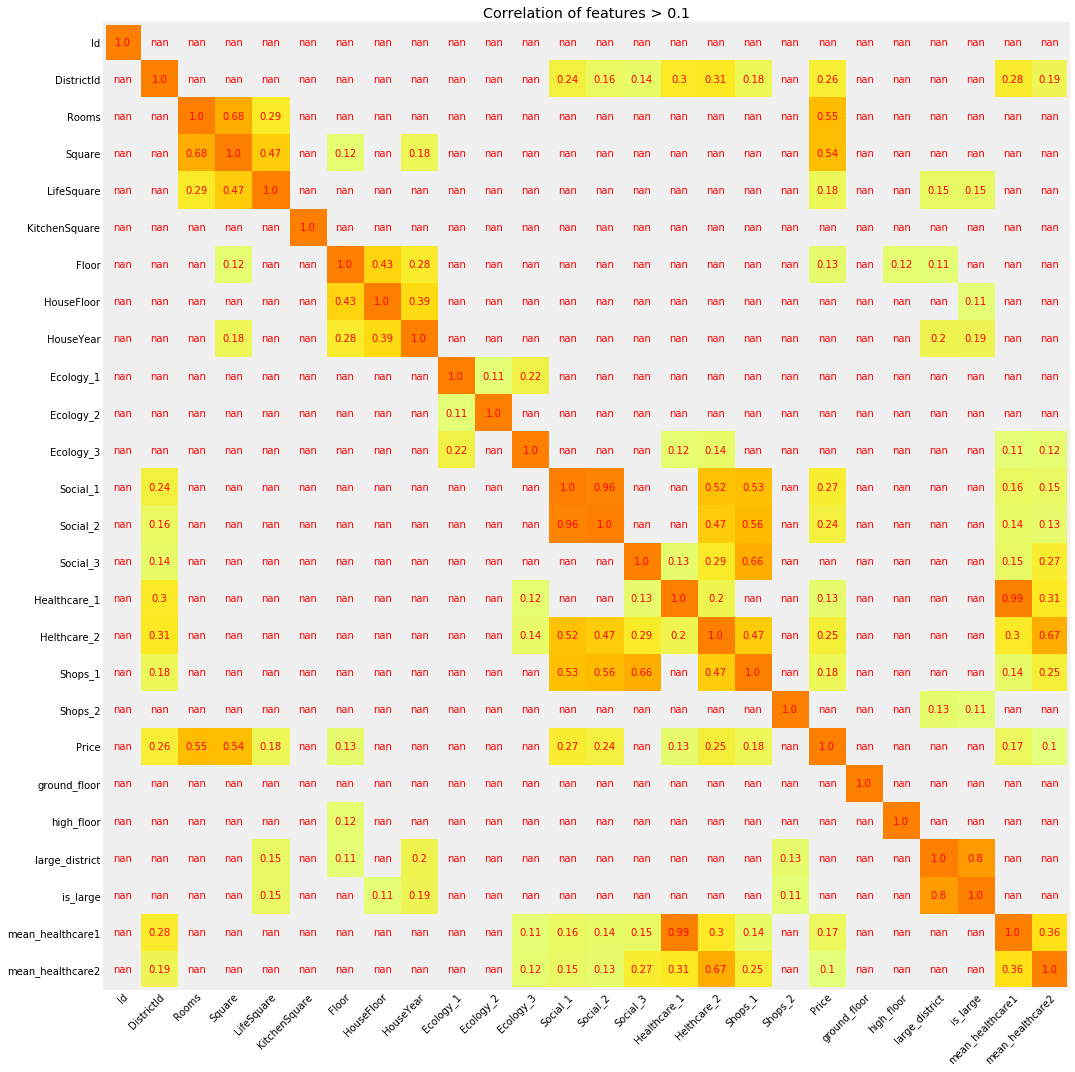

In [25]:
data_columns = train.columns
correlation = train.corr()
# прорисовываем температурную карту (heatmap) по перекрессной корреляции показателей
# для определения наиболее взаимозависимых показателей

# Размер графика
rcParams['figure.figsize'] = 15, 15
# Задаем отсекающий коэффициент корреляции. Ниже этого коэфф. считаем, что корреляция пары показателей не сильная.
correlation_rate_filter = 0.1

#Определяем колонки, столбцы и данные для построение heatmap
hm_index = correlation.index
hm_colums = correlation.columns
hm_data = np.array(correlation.where(correlation > abs(correlation_rate_filter))).round(2)


fig, ax = plt.subplots()
im = ax.imshow(hm_data, cmap="Wistia")

# Столбцы и индексы
ax.set_xticks(np.arange(len(hm_colums)))
ax.set_yticks(np.arange(len(hm_index)))
ax.set_xticklabels(hm_colums)
ax.set_yticklabels(hm_index)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Подписи к столбцам и индексам.
for i in range(len(hm_index)):
    for j in range(len(hm_colums)):
        text = ax.text(j, i, hm_data[i, j],
                       ha="center", va="center", color="r", fontsize=10)

ax.set_title(f"Correlation of features > {correlation_rate_filter}")
fig.tight_layout()
plt.grid()
plt.show()

# Деревья решений 

In [26]:
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.metrics import r2_score as r2

In [27]:
train.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price', 'ground_floor',
       'high_floor', 'large_district', 'is_large', 'mean_healthcare1',
       'mean_healthcare2'],
      dtype='object')

In [28]:
col = list(train.columns)
col.remove ('Price') # Целевое значение
col.remove ('Healthcare_1') # большое количество не заполнееных данных

In [29]:
feats = list (col)
rf = RF(n_estimators=30, max_depth=10, random_state=42)
rf.fit(train.loc[:, feats], train['Price'])
pred1 = rf.predict(valid.loc[:, feats])
sc = r2(valid['Price'], pred1)
sc

0.69818405918631

In [30]:
# Определяем признаки которые влияеют на модель
for i in range (len(col)-1, -1, -1):
    feats = list (col)
    a = feats [i]
    del feats [i]
    rf = RF(n_estimators=30, max_depth=10, random_state=42)
    rf.fit(train.loc[:, feats], train['Price'])
    pred1 = rf.predict(valid.loc[:, feats])
    hk = r2(valid['Price'], pred1)
    if hk >= sc:
        col.remove(a)
        sc = hk
col

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Social_3',
 'Shops_1',
 'Shops_2',
 'ground_floor',
 'high_floor',
 'large_district',
 'mean_healthcare1']

In [31]:
feats = list (col)

In [32]:
model = RF(n_estimators=118, max_depth=12, random_state=42)

In [33]:
model.fit(train.loc[:, feats], train['Price'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=118, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [34]:
def evaluate_model(df, model=model, feats=feats, calculate_r2='Yes'):
    pred = model.predict(df.loc[:, feats])
    if calculate_r2 == 'Yes':
        r2_ = r2(df['Price'], pred)
        print('R2: {}'.format(r2_))
    return pred

In [35]:
pred_train = evaluate_model(train)

R2: 0.9055691644760122


In [36]:
pred_valid = evaluate_model(valid)

R2: 0.7273414224318067


In [37]:
# Поределяем лучшее параметры для леса деревьев
mdepth = range(5,40)
est =range(20,150)
max_r2=0
dip=0
e=0
max_est = 0
score = []
r2_est = []
for i in mdepth:
    rf = RF(n_estimators=30, max_depth=i, random_state=42)
    rf.fit(train.loc[:, feats], train['Price'])
    pred1 = rf.predict(valid.loc[:, feats])
    sc = r2(valid['Price'], pred1)
    if sc > max_r2:
        max_r2 = sc
        dip = i
    score.append(sc)
for i in est:
    rf = RF(n_estimators=i, max_depth=dip, random_state=42)
    rf.fit(train.loc[:, feats], train['Price'])
    pred1 = rf.predict(valid.loc[:, feats])
    sc = r2(valid['Price'], pred1)
    if sc > max_est:
        max_est = sc
        e = i
    r2_est.append(sc)
print('Лучший показатель R2 =', max_est,'получается при: max_depth =',dip,'и n_estimators = ',e)

Лучший показатель R2 = 0.7273414224318067 получается при: max_depth = 12 и n_estimators =  118


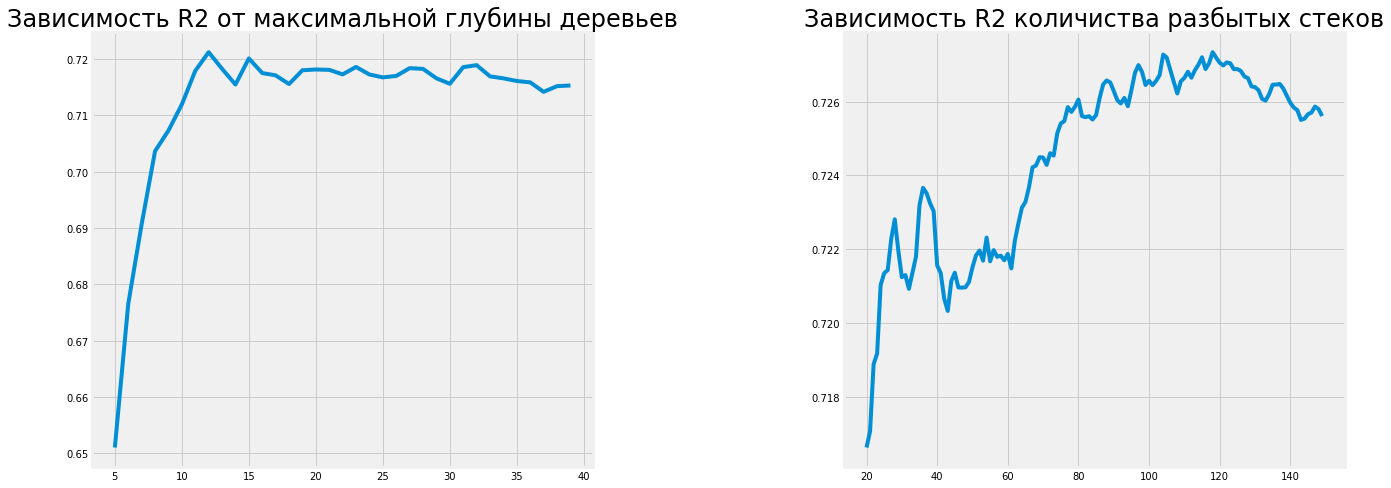

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=2)
[ax1, ax2] = ax
ax1.plot(mdepth, score)
ax1.set_title('Зависимость R2 от максимальной глубины деревьев', fontsize=24)
ax2.plot(est, r2_est)
ax2.set_title('Зависимость R2 количиства разбытых стеков', fontsize=24)

fig.set_size_inches(20, 8 )
plt.subplots_adjust(wspace=0.5)

In [39]:
model = RF(n_estimators=118, max_depth=12, random_state=42)
model.fit(train.loc[:, feats], train['Price'])
pred_valid = evaluate_model(valid)

R2: 0.7273414224318067


# Предсказание на тестовых данных

In [40]:
test = pd.read_csv('test.csv')
test.shape

(5000, 19)

In [41]:
test = prepare_data(test) 
test.shape

(5000, 25)

In [42]:
test['Price'] = evaluate_model(test, calculate_r2='No')

In [43]:
test['Price'].head(10)

0    172349.717408
1    226038.317206
2    237001.675490
3    298618.924553
4    138386.437274
5    197255.945648
6    165412.083103
7    216494.343374
8    280464.071636
9    212776.765481
Name: Price, dtype: float64

In [44]:
test.loc[:, ['Id', 'Price']].to_csv('Rymiantsev_predictions.csv', index=None)